# Fraud prediction models and threshold analysis

In this notebook, we will worked with logistic regression, SVC and XGBoost models, also changing threshold to see its impact on recall and f1 score, which are very important to fraud detection applications, to reduce the occurrence of false negatives.

# Load data

In [1]:
import numpy as np
import pandas as pd

In [2]:
df_test =  pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')
df_train =  pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv')

In [3]:
print(len(df_train), len(df_test))

1296675 555719


We are goinh to use both dataframes, test and train, into one, with union operation

In [4]:
df_complete = pd.concat([df_train, df_test])
len(df_complete)

1852394

In [5]:
df_complete.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


# Data Understanding and Exploration

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='is_fraud'>

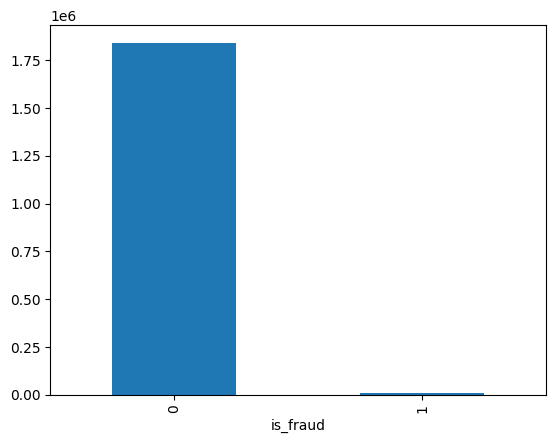

In [7]:
df_complete.groupby('is_fraud').count()['cc_num'].plot.bar()

We can see that, as usual, the number of fraudulent transactions is much smaller, which can lead our model to predict non fraudulent (0) with higher performance than fraud (1) transactions.

In [8]:
fraud = df_complete[df_complete['is_fraud'] == 1]
non_fraud = df_complete[df_complete['is_fraud'] == 0]

print(len(fraud), len(non_fraud))

9651 1842743


In [9]:
df_complete.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,5.371934e+05,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03
std,3.669110e+05,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00
25%,2.315490e+05,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00
50%,4.630980e+05,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00
75%,8.335758e+05,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [10]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud               i

# Checking distinct

In [11]:
df_complete.nunique()

Unnamed: 0               1296675
trans_date_trans_time    1819551
cc_num                       999
merchant                     693
category                      14
amt                        60616
first                        355
last                         486
gender                         2
street                       999
city                         906
state                         51
zip                          985
lat                          983
long                         983
city_pop                     891
job                          497
dob                          984
trans_num                1852394
unix_time                1819583
merch_lat                1754157
merch_long               1809753
is_fraud                       2
dtype: int64

# Checking for NaN/null and duplicated cells

In [12]:
df_complete.isna().sum().sum()

0

In [13]:
df_complete.duplicated().sum()

0

We are not going to analyze outliers for they can be important to detect frauds.

<Axes: >

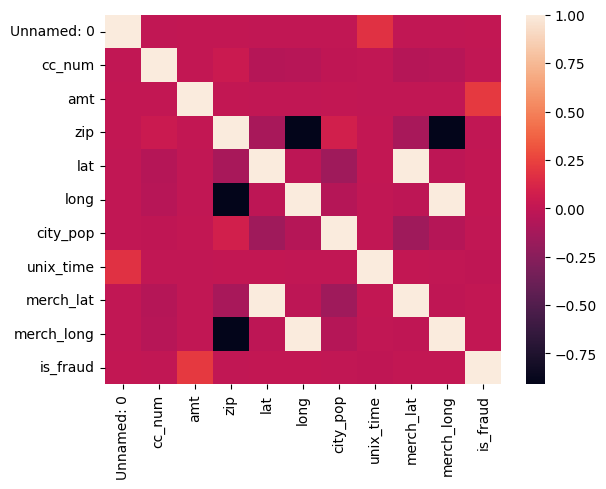

In [14]:
sns.heatmap(df_complete[[i for i in df_complete.columns\
                         if df_complete[i].dtype == 'int64' \
                            or df_complete[i].dtype == 'float64']]\
                            .corr())

This shows greater correlation of 'is_fraud' column with 'amt' variable

# Data Preparation

### Balancing the dataset

In [15]:
df_balanced = pd.concat([fraud, non_fraud.sample(len(fraud), random_state= 42)])

In [16]:
df_balanced.shape

(19302, 23)

<Axes: xlabel='is_fraud'>

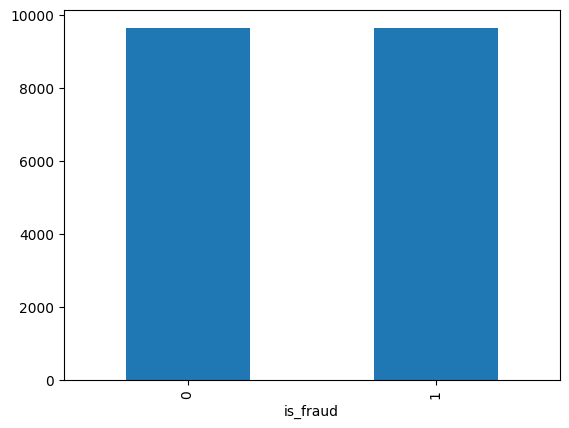

In [17]:
df_balanced.groupby('is_fraud').count()['cc_num'].plot.bar()

### Dropping columns

In [18]:
# Dropping columns not relevant for this case
columns_dropped = ['Unnamed: 0',
                   'merchant', 
                   'cc_num',
                   'first', 
                   'last',
                   'gender',
                   'trans_num',
                   'unix_time',
                   'street',
                   'merch_lat',
                   'merch_long',
                   'job',
                   'zip',
                   ]

df_balanced.drop(columns = columns_dropped, inplace = True)

In [19]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19302 entries, 2449 to 135673
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  19302 non-null  object 
 1   category               19302 non-null  object 
 2   amt                    19302 non-null  float64
 3   city                   19302 non-null  object 
 4   state                  19302 non-null  object 
 5   lat                    19302 non-null  float64
 6   long                   19302 non-null  float64
 7   city_pop               19302 non-null  int64  
 8   dob                    19302 non-null  object 
 9   is_fraud               19302 non-null  int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 1.6+ MB


### Feature Engineering: Managing datetimes

In [20]:
# First, I'm converting 'trans_date_trans_time' and 'dob' into datetime type
df_balanced['trans_date_trans_time'] = pd.to_datetime(df_balanced['trans_date_trans_time'])
df_balanced['dob'] = pd.to_datetime(df_balanced['dob'])

In [21]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19302 entries, 2449 to 135673
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   trans_date_trans_time  19302 non-null  datetime64[ns]
 1   category               19302 non-null  object        
 2   amt                    19302 non-null  float64       
 3   city                   19302 non-null  object        
 4   state                  19302 non-null  object        
 5   lat                    19302 non-null  float64       
 6   long                   19302 non-null  float64       
 7   city_pop               19302 non-null  int64         
 8   dob                    19302 non-null  datetime64[ns]
 9   is_fraud               19302 non-null  int64         
dtypes: datetime64[ns](2), float64(3), int64(2), object(3)
memory usage: 1.6+ MB


In [22]:
# Now, we can use these datetime variables to extract relevant information
# about the transaction and the client, such as day hour and age

# Lets change these columns
df_balanced['trans_date_trans_time'] = df_balanced['trans_date_trans_time'].dt.hour

In [23]:
df_balanced = df_balanced.rename(columns = {'trans_date_trans_time': 'hour_transaction'})

In [24]:
# Function to get time of day
def get_tod(hour):
    if 4 < hour['hour_transaction'] <= 12:
        ans = 'morning'
    elif 12 < hour['hour_transaction'] <= 20:
        ans = 'afternoon'
    elif hour['hour_transaction'] <= 4 or hour['hour_transaction'] > 20:
        ans = 'night'
    return ans

In [25]:
df_balanced['hour_transaction'] = df_balanced.apply(get_tod, axis = 1)

In [26]:
df_balanced.head()

,hour_transaction,category,amt,city,state,lat,long,city_pop,dob,is_fraud
2449,night,grocery_pos,281.06,Collettsville,NC,35.9946,-81.7266,885,1988-09-15,1
2472,night,gas_transport,11.52,San Antonio,TX,29.4400,-98.4590,1595797,1960-10-28,1
2523,night,grocery_pos,276.31,San Antonio,TX,29.4400,-98.4590,1595797,1960-10-28,1
2546,night,gas_transport,7.03,Collettsville,NC,35.9946,-81.7266,885,1988-09-15,1
2553,night,grocery_pos,275.73,San Antonio,TX,29.4400,-98.4590,1595797,1960-10-28,1


In [27]:
# Now, about 'dob' (day of birth), we can get the age of the user
df_balanced['dob']= df_balanced['dob'].dt.year
df_balanced = df_balanced.rename(columns = {'dob': 'age'})

In [28]:
from datetime import datetime
df_balanced['age'] = datetime.now().year - df_balanced['age']

In [29]:
# Analyzing how many frauds occur for each age group
df_balanced[df_balanced['is_fraud'] == 1].groupby('age').count()['is_fraud']

age
19      7
20     32
21     21
22     12
23     58
       ..
96     41
97     54
98     33
99     11
100     7
Name: is_fraud, Length: 82, dtype: int64

In [30]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19302 entries, 2449 to 135673
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hour_transaction  19302 non-null  object 
 1   category          19302 non-null  object 
 2   amt               19302 non-null  float64
 3   city              19302 non-null  object 
 4   state             19302 non-null  object 
 5   lat               19302 non-null  float64
 6   long              19302 non-null  float64
 7   city_pop          19302 non-null  int64  
 8   age               19302 non-null  int32  
 9   is_fraud          19302 non-null  int64  
dtypes: float64(3), int32(1), int64(2), object(4)
memory usage: 1.5+ MB


### Label Encoding

Using label encoding for categorical data

In [31]:
NUMERICAL_FEATURES = [i for i in df_balanced.columns if df_balanced[i].dtype == 'int64'\
                      or df_balanced[i].dtype =='int32' \
                      or df_balanced[i].dtype =='float64']
CATEGORICAL_FEATURES = [i for i in df_balanced.columns if df_balanced[i].dtype == 'object']

In [32]:
NUMERICAL_FEATURES

['amt', 'lat', 'long', 'city_pop', 'age', 'is_fraud']

In [33]:
CATEGORICAL_FEATURES

['hour_transaction', 'category', 'city', 'state']

In [34]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
encoder.fit(df_balanced[CATEGORICAL_FEATURES])

df_balanced[CATEGORICAL_FEATURES] = encoder.transform(df_balanced[CATEGORICAL_FEATURES])

In [35]:
df_balanced.head()

,hour_transaction,category,amt,city,state,lat,long,city_pop,age,is_fraud
2449,2.0,4.0,281.06,165.0,27.0,35.9946,-81.7266,885,36,1
2472,2.0,2.0,11.52,733.0,43.0,29.4400,-98.4590,1595797,64,1
2523,2.0,4.0,276.31,733.0,43.0,29.4400,-98.4590,1595797,64,1
2546,2.0,2.0,7.03,165.0,27.0,35.9946,-81.7266,885,36,1
2553,2.0,4.0,275.73,733.0,43.0,29.4400,-98.4590,1595797,64,1


### Correcting datatypes

In [36]:
df_balanced[['is_fraud', 'age']] = df_balanced[['is_fraud', 'age']].astype('float64')

### Scaling dataset

As I'm trying different models, such as SVM which relies on distance, I'll scale the dataset.

<Axes: >

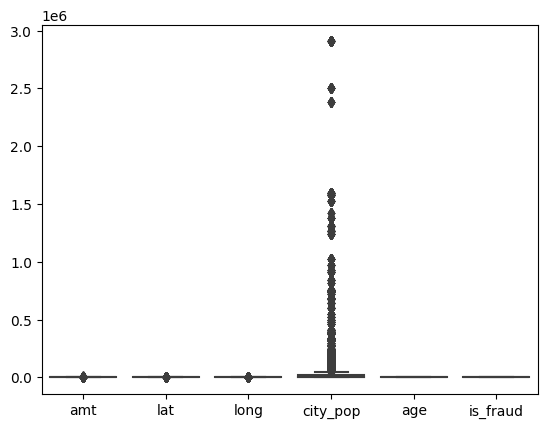

In [37]:
sns.boxplot(df_balanced[NUMERICAL_FEATURES])

<Axes: >

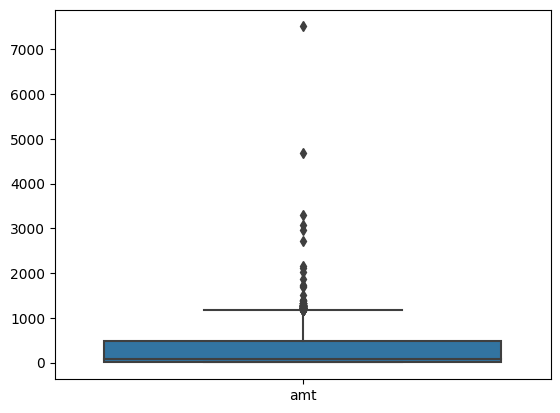

In [38]:
sns.boxplot(df_balanced[['amt']])

And not all of them seem to follow a gaussian normal distribution, so we are using normal minmax scaler.

In [39]:
# Using min max scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_balanced)
df_scaled = pd.DataFrame(df_scaled)

In [40]:
last_column = df_scaled.shape[1]-1

In [41]:
print(f"Not fraud: {df_scaled[df_scaled[last_column] == 0].count()[last_column]}")
print(f"Fraud: {df_scaled[df_scaled[last_column] == 1].count()[last_column]}")

Not fraud: 9651
Fraud: 9651


In [42]:
df_scaled.rename(columns={last_column: 'is_fraud'}, inplace=True)
df_scaled.head()

,0,1,2,3,4,5,6,7,8,is_fraud
0,1.0,0.307692,0.037304,0.182320,0.54,0.342164,0.859026,0.000297,0.209877,1.0
1,1.0,0.153846,0.001401,0.809945,0.86,0.201707,0.687801,0.549003,0.555556,1.0
2,1.0,0.307692,0.036672,0.809945,0.86,0.201707,0.687801,0.549003,0.555556,1.0
3,1.0,0.153846,0.000803,0.182320,0.54,0.342164,0.859026,0.000297,0.209877,1.0
4,1.0,0.307692,0.036594,0.809945,0.86,0.201707,0.687801,0.549003,0.555556,1.0


# Modeling

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [44]:
# X = feature values, all the columns except the last column
X = df_scaled.drop(columns = 'is_fraud')

# y = target values, last column of the data frame
y = df_scaled['is_fraud']

In [45]:
# Spliting train and test - hold out
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression model

In [46]:
# Training
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [47]:
# Now let's define a function to get the predictions and set the threshold

def predict(model, test_set, threshold):
    predictions = model.predict(test_set)
    pred_threshold = model.predict_proba(test_set)
    test_set["prediction"] = predictions
    test_set["pred_threshold"] = (pred_threshold >= threshold)[:, 1].astype(float)
    return test_set

In [48]:
# Use 0.4 as threshold for LR model
predict(model, x_test, 0.4)

,0,1,2,3,4,5,6,7,8,prediction,pred_threshold
10529,0.0,0.923077,0.000032,0.230939,0.18,0.190112,0.863930,0.030520,0.209877,0.0,0.0
15361,0.5,0.153846,0.008027,0.717127,0.02,0.306858,0.797742,0.001980,0.654321,0.0,0.0
12160,0.0,0.769231,0.010819,0.818785,0.76,0.434610,0.914594,0.000275,0.283951,0.0,0.0
2953,1.0,0.384615,0.002729,0.709392,0.86,0.244708,0.635407,0.004378,0.222222,0.0,1.0
15870,0.0,0.000000,0.009766,0.477348,0.46,0.518806,0.720395,0.000511,0.148148,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
17155,0.0,0.692308,0.000574,0.093923,0.42,0.514942,0.979377,0.001101,0.098765,0.0,0.0
17454,0.5,0.153846,0.006062,0.976796,0.48,0.358675,0.732927,0.000254,0.246914,0.0,0.0
12681,1.0,1.000000,0.001007,0.977901,0.20,0.232642,0.832440,0.001172,0.679012,0.0,0.0
15764,0.0,0.384615,0.000481,0.667403,0.08,0.380590,0.444976,0.131228,0.382716,0.0,0.0


The 'prediction' column is for standard threshold (0.5) and the 'pred_threshold' stands for our results with the changed threshold.

In [49]:
y_test = pd.DataFrame(y_test)

In [50]:
x_test["real"] = y_test["is_fraud"]

In [51]:
x_test.head(5)

,0,1,2,3,4,5,6,7,8,prediction,pred_threshold,real
10529,0.0,0.923077,0.000032,0.230939,0.18,0.190112,0.863930,0.030520,0.209877,0.0,0.0,0.0
15361,0.5,0.153846,0.008027,0.717127,0.02,0.306858,0.797742,0.001980,0.654321,0.0,0.0,0.0
12160,0.0,0.769231,0.010819,0.818785,0.76,0.434610,0.914594,0.000275,0.283951,0.0,0.0,0.0
2953,1.0,0.384615,0.002729,0.709392,0.86,0.244708,0.635407,0.004378,0.222222,0.0,1.0,1.0
15870,0.0,0.000000,0.009766,0.477348,0.46,0.518806,0.720395,0.000511,0.148148,0.0,0.0,0.0


In [52]:
# With 0.5 threshold
print(classification_report(x_test['real'], x_test['prediction']))

              precision    recall  f1-score   support

         0.0       0.79      0.82      0.80      1932
         1.0       0.81      0.78      0.80      1929

    accuracy                           0.80      3861
   macro avg       0.80      0.80      0.80      3861
weighted avg       0.80      0.80      0.80      3861



In [53]:
# With 0.4 threshold
print(classification_report(x_test['real'], x_test['pred_threshold']))

              precision    recall  f1-score   support

         0.0       0.93      0.70      0.80      1932
         1.0       0.76      0.94      0.84      1929

    accuracy                           0.82      3861
   macro avg       0.84      0.82      0.82      3861
weighted avg       0.84      0.82      0.82      3861



We can see an improvement in the recall for frauds, which is now 0.94, but also some other metrics such as precision got a little bit worse.

The F1-score overall got better!

In [54]:
# Let's define now a function to get the confusion matrix
def confusion_matrix_plot(test_set, pred_label, model):
    cm = confusion_matrix(x_test['real'], x_test[pred_label], labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
    disp.plot()
    plt.show()

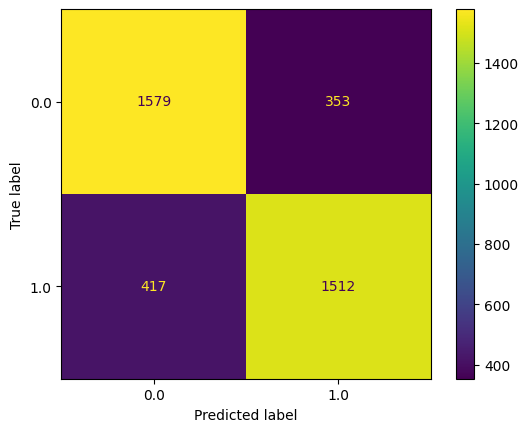

In [55]:
confusion_matrix_plot(x_test, 'prediction', model)

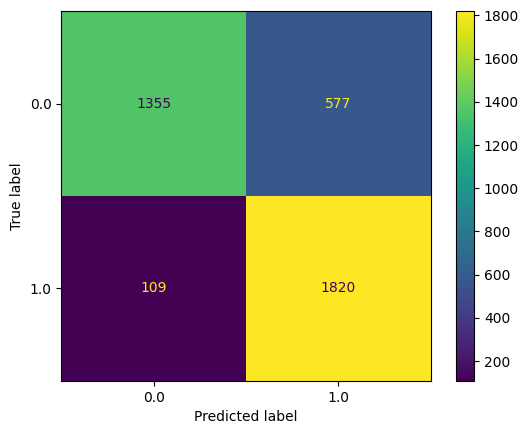

In [56]:
confusion_matrix_plot(x_test, 'pred_threshold', model)

This way, we got way better at predicting fraud transactions, but worse to predict non fraud.

# SVM Classifier Model

Let's try now with SVC model

In [57]:
from sklearn.svm import SVC

In [58]:
model_SVM = SVC(probability = True, random_state=42)

In [59]:
model_SVM.fit(x_train, y_train)

SVC(probability=True, random_state=42)

In [60]:
# Dropping our last predictions
x_test = x_test.drop(columns = {'prediction','pred_threshold' ,'real'})

In [61]:
# Use 0.4 as threshold for LR model
predict(model_SVM, x_test, 0.4)

,0,1,2,3,4,5,6,7,8,prediction,pred_threshold
10529,0.0,0.923077,0.000032,0.230939,0.18,0.190112,0.863930,0.030520,0.209877,0.0,0.0
15361,0.5,0.153846,0.008027,0.717127,0.02,0.306858,0.797742,0.001980,0.654321,0.0,0.0
12160,0.0,0.769231,0.010819,0.818785,0.76,0.434610,0.914594,0.000275,0.283951,0.0,0.0
2953,1.0,0.384615,0.002729,0.709392,0.86,0.244708,0.635407,0.004378,0.222222,1.0,1.0
15870,0.0,0.000000,0.009766,0.477348,0.46,0.518806,0.720395,0.000511,0.148148,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
17155,0.0,0.692308,0.000574,0.093923,0.42,0.514942,0.979377,0.001101,0.098765,0.0,0.0
17454,0.5,0.153846,0.006062,0.976796,0.48,0.358675,0.732927,0.000254,0.246914,0.0,0.0
12681,1.0,1.000000,0.001007,0.977901,0.20,0.232642,0.832440,0.001172,0.679012,0.0,0.0
15764,0.0,0.384615,0.000481,0.667403,0.08,0.380590,0.444976,0.131228,0.382716,0.0,0.0


In [62]:
x_test["real"] = y_test["is_fraud"]

# With 0.5 threshold
print(classification_report(x_test['real'], x_test['prediction']))
# With 0.4 threshold
print(classification_report(x_test['real'], x_test['pred_threshold']))

              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84      1932
         1.0       0.84      0.85      0.84      1929

    accuracy                           0.84      3861
   macro avg       0.84      0.84      0.84      3861
weighted avg       0.84      0.84      0.84      3861

              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83      1932
         1.0       0.81      0.87      0.84      1929

    accuracy                           0.83      3861
   macro avg       0.84      0.83      0.83      3861
weighted avg       0.84      0.83      0.83      3861



In this case, we've got more balanced metrics, and a little improvement in recall. The f1-score is somewhat similar to LR.

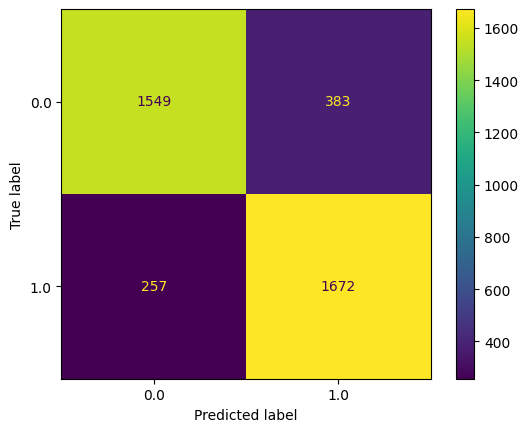

In [63]:
confusion_matrix_plot(x_test, 'pred_threshold', model_SVM)

# XGBoost Model

Finally, we will implement XGBoost model and compare with LR and SVC.

In [64]:
from xgboost import XGBClassifier

In [65]:
# XGBoost classifier model
xgb = XGBClassifier(objective='binary:logistic')

In [66]:
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [67]:
# Drop again our last predictions
x_test = x_test.drop(columns = {'prediction','pred_threshold' ,'real'})

In [68]:
# Experimenting 0.3 threshold for XGBoost model
predict(xgb, x_test, 0.3)

,0,1,2,3,4,5,6,7,8,prediction,pred_threshold
10529,0.0,0.923077,0.000032,0.230939,0.18,0.190112,0.863930,0.030520,0.209877,0,0.0
15361,0.5,0.153846,0.008027,0.717127,0.02,0.306858,0.797742,0.001980,0.654321,0,0.0
12160,0.0,0.769231,0.010819,0.818785,0.76,0.434610,0.914594,0.000275,0.283951,0,0.0
2953,1.0,0.384615,0.002729,0.709392,0.86,0.244708,0.635407,0.004378,0.222222,1,1.0
15870,0.0,0.000000,0.009766,0.477348,0.46,0.518806,0.720395,0.000511,0.148148,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
17155,0.0,0.692308,0.000574,0.093923,0.42,0.514942,0.979377,0.001101,0.098765,0,0.0
17454,0.5,0.153846,0.006062,0.976796,0.48,0.358675,0.732927,0.000254,0.246914,0,0.0
12681,1.0,1.000000,0.001007,0.977901,0.20,0.232642,0.832440,0.001172,0.679012,1,1.0
15764,0.0,0.384615,0.000481,0.667403,0.08,0.380590,0.444976,0.131228,0.382716,0,0.0


In [69]:
x_test["real"] = y_test["is_fraud"]
print(classification_report(x_test['real'], x_test['prediction']))
print(classification_report(x_test['real'], x_test['pred_threshold']))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97      1932
         1.0       0.97      0.98      0.97      1929

    accuracy                           0.97      3861
   macro avg       0.97      0.97      0.97      3861
weighted avg       0.97      0.97      0.97      3861

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      1932
         1.0       0.96      0.98      0.97      1929

    accuracy                           0.97      3861
   macro avg       0.97      0.97      0.97      3861
weighted avg       0.97      0.97      0.97      3861



XGBoost got overall some much better results than the previous models, and we see also that in this case, reducing threshold to 0.3 got to a little bit worse model, which means that there is a different ROC (Receiver Operating Curve) behavior to this model

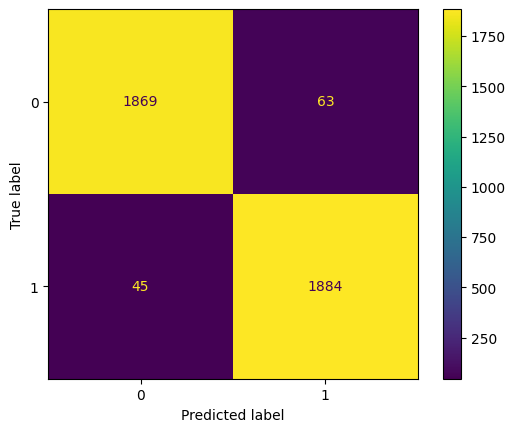

In [70]:
confusion_matrix_plot(x_test, 'prediction', xgb)